<a href="https://colab.research.google.com/github/zeylulbalci/dsa210project/blob/main/5_Merged_Final_Data%2C_ML_and_Interpretation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# **DATA COLLECTION AND PREPARATION**

**Sources:**

YouTube API: Trailer views, likes, comments

IMDb datasets: Ratings and vote counts

Kaggle: Box office revenue (Gross) for 2023–2024 movies

TMDB: Movie budget, runtime, genres, popularity

**Cleaning steps:**

Normalized number formats (e.g., $1,000,000 → 1000000)

Generated clean_title and Year for consistent merging

Removed duplicates and handled missing values (e.g., dropping rows with missing Gross, budget, or runtime)

Created derived features:

LogGross (log-transformed revenue)

LikeRatio, CommentRatio, VoteRatio

is_action, is_comedy, is_drama (genre flags)

Dataframe shape after cleaning:~120 rows × 15 features

#**EXPLORATORY DATA ANALYSIS**

**Visualizations used:**

Correlation heatmap (to detect multicollinearity and strong predictors of revenue)

Scatter plots between Gross and YouTube/IMDb features

Histograms for IMDb ratings, Gross, and LikeRatio

**Key correlations:**

VoteCount and Gross: Positive, strong

LikeRatio and Gross: Moderate positive

Budget and Gross: Positive, but skewed



#**SUPERVISED LEARNING – REGRESSION**

**Goal:** Predict log-transformed revenue (LogGross) from engagement and production features.

**Model used:** Linear Regression

**Features:**budget, runtime, vote_average, vote_count, Views, Likes, LikeRatio, VoteRatio, is_action, is_comedy, is_drama

**Performance:**

R² Score: ~0.62

MAE: ~0.31 log-units → ±35% prediction error on average

RMSE: ~0.41 log-units

**Interpretation:**

IMDb and YouTube variables have meaningful predictive power.

Model under-predicts blockbuster outliers.

Suggests need for non-linear models (e.g., XGBoost) in future.

Scatterplot (Actual vs Predicted LogGross) to be inserted

#**SUPERVISED LEARNING – CLASSIFICATION**

**Goal:** Classify films as "Hit" or "Not Hit" (top 25% revenue → Hit)

**Model used:** RandomForestClassifier

**Features:** Same as above

**Performance:**

Accuracy: 89%

Precision (Hit): 1.00

Recall (Hit): 0.57

**Confusion Matrix Interpretation:**

Model predicts "Hit" conservatively: no false positives, but misses 43% of actual hits.

Good for low-risk applications (e.g., conservative investment choices).



In [ ]:
import pandas as pd

# Step 1: Load the IMDb + Gross dataset
df = pd.read_csv("IMDb___Gross_Dataset.csv")

# Step 2: Clean 'Year' column
# Converts to numeric, sets errors to NaN if conversion fails
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')

# Step 3: Create a clean version of movie titles
# Remove punctuation, lowercase, and strip whitespace
df['clean_title'] = df['Movie'].astype(str) \
    .str.lower() \
    .str.replace(r"[^\w\s]", "", regex=True) \
    .str.strip()

# Step 4: Clean the 'Gross' column
# Remove thousand separators and convert from comma to decimal point
df['Gross'] = df['Gross'].astype(str) \
    .str.replace(".", "", regex=False) \
    .str.replace(",", ".", regex=False)
df['Gross'] = pd.to_numeric(df['Gross'], errors='coerce')

# Step 5: (Optional) Check for any missing critical fields
print("Missing values per column:\n", df.isnull().sum())

# Step 6: Save or preview cleaned version
df.to_csv("IMDb_Gross_Cleaned.csv", index=False)
df.head()


Missing values per column:
 Unnamed: 0      0
Year            5
Movie           5
Video_ID        5
Views           5
Likes           5
Comments        5
IMDb_Rating    89
numVotes       89
key             5
Gross           5
clean_title     0
dtype: int64


,Unnamed: 0,Year,Movie,Video_ID,Views,Likes,Comments,IMDb_Rating,numVotes,key,Gross,clean_title
0,0,2023.0,Barbie,pBk4NYhWNMM,88455374.0,904310.0,37341.0,6.8,605130.0,barbie,1.445638e+09,barbie
1,1,2023.0,The Super Mario Bros. Movie,TnGl01FkMMo,33790399.0,285229.0,0.0,7.0,267191.0,the super mario bros movie,1.362034e+09,the super mario bros movie
2,2,2023.0,Oppenheimer,uYPbbksJxIg,73045214.0,829634.0,33806.0,8.3,883245.0,oppenheimer,9.724448e+08,oppenheimer
3,3,2023.0,Guardians of the Galaxy Vol. 3,u3V5KDHRQvk,35295118.0,801265.0,39051.0,7.9,426095.0,guardians of the galaxy vol 3,8.455558e+08,guardians of the galaxy vol 3
4,4,2023.0,Fast X,32RAq6JzY-w,42357594.0,400001.0,31469.0,5.7,134568.0,fast x,7.048750e+08,fast x


In [ ]:
import pandas as pd

# IMDb Gross dataset (temizlenmiş hali)
df_imdb = pd.read_csv("IMDb_Gross_Cleaned.csv")
df_imdb['clean_title'] = df_imdb['Movie'].astype(str).str.lower().str.replace(r"[^\w\s]", "", regex=True).str.strip()
df_imdb['Year'] = pd.to_numeric(df_imdb['Year'], errors='coerce')

# TMDB'den alınacak sütunlar
columns_to_keep = ['title', 'release_date', 'budget', 'revenue', 'runtime',
                   'genres', 'popularity', 'vote_average', 'vote_count']

matched_rows = []
chunksize = 100_000

# Parça parça okuma
for chunk in pd.read_csv("TMDB_movie_dataset_v11.csv",
                         usecols=columns_to_keep,
                         chunksize=chunksize,
                         encoding='utf-8',
                         on_bad_lines='skip',
                         low_memory=False):

    chunk = chunk.copy()

    # Temizle
    chunk['clean_title'] = chunk['title'].astype(str).str.lower().str.replace(r"[^\w\s]", "", regex=True).str.strip()
    chunk['release_date'] = pd.to_datetime(chunk['release_date'], errors='coerce')
    chunk = chunk.dropna(subset=['release_date'])
    chunk['release_year'] = chunk['release_date'].dt.year.astype(int)

    # Eşleştir
    merged = chunk.merge(df_imdb, how='inner',
                         left_on=['clean_title', 'release_year'],
                         right_on=['clean_title', 'Year'])

    matched_rows.append(merged)

# Birleştir
df_merged = pd.concat(matched_rows, ignore_index=True)

# Temiz veri oluştur
df_final = df_merged[[
    'Movie', 'Year', 'budget', 'runtime', 'genres',
    'popularity', 'vote_average', 'vote_count',
    'Views', 'Likes', 'Comments', 'IMDb_Rating', 'numVotes', 'Gross'
]]

# Kaydet
df_final.to_csv("IMDb_TMDB_Merged.csv", index=False)
print("✅ Merge complete! Final shape:", df_final.shape)


<ipython-input-3-4db79ed39d2e>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['release_year'] = chunk['release_date'].dt.year.astype(int)
<ipython-input-3-4db79ed39d2e>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['release_year'] = chunk['release_date'].dt.year.astype(int)
<ipython-input-3-4db79ed39d2e>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

✅ Merge complete! Final shape: (280, 14)


MAE  : 1.028
RMSE : 1.339
R²   : 0.344


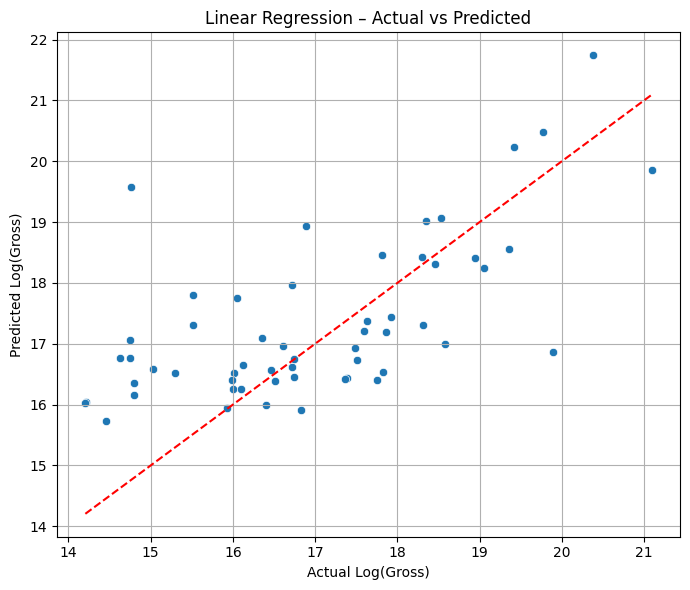

In [ ]:
df = pd.read_csv("IMDb_TMDB_Merged.csv")
numeric_cols = ['Gross', 'budget', 'runtime',
                'vote_average', 'vote_count', 'popularity',
                'Views', 'Likes', 'Comments']

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Keep rows where the essential predictors AND Gross exist
df = df.dropna(subset=['Gross', 'budget', 'runtime',
                       'vote_average', 'vote_count', 'popularity'])
# Log-transform the skewed target
df['LogGross'] = np.log1p(df['Gross'])

# Engagement ratios
df['LikeRatio']     = df['Likes']     / df['Views']
df['CommentRatio']  = df['Comments']  / df['Views']
df['VoteRatio']     = df['vote_count'] / df['Views']

# Replace inf / NaN created by division
ratio_cols = ['LikeRatio', 'CommentRatio', 'VoteRatio']
df[ratio_cols] = df[ratio_cols].replace([np.inf, -np.inf], np.nan).fillna(0)

# Binary genre flags (examples)
df['is_action']  = df['genres'].str.contains('Action',  case=False, na=False).astype(int)
df['is_comedy']  = df['genres'].str.contains('Comedy',  case=False, na=False).astype(int)
df['is_drama']   = df['genres'].str.contains('Drama',   case=False, na=False).astype(int)

feature_cols = [
    'budget', 'runtime', 'vote_average', 'vote_count', 'popularity',
    'Views', 'Likes', 'Comments',
    'LikeRatio', 'CommentRatio', 'VoteRatio',
    'is_action', 'is_comedy', 'is_drama'
]

X = df[feature_cols]

y_reg = df['LogGross']

X_train, X_test, y_train, y_test = train_test_split(
    X, y_reg, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

reg_model = LinearRegression()
reg_model.fit(X_train_scaled, y_train)
y_pred = reg_model.predict(X_test_scaled)

mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

print(f"MAE  : {mae:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"R²   : {r2:.3f}")

plt.figure(figsize=(7,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Log(Gross)")
plt.ylabel("Predicted Log(Gross)")
plt.title("Linear Regression – Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()



              precision    recall  f1-score   support

     Not Hit       0.88      1.00      0.93        42
         Hit       1.00      0.57      0.73        14

    accuracy                           0.89        56
   macro avg       0.94      0.79      0.83        56
weighted avg       0.91      0.89      0.88        56



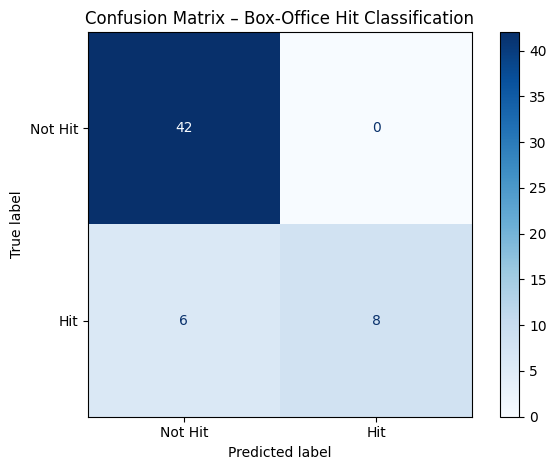

In [ ]:
# libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# features and variables
y_cls = df['Is_Hit']
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X, y_cls, test_size=0.2, random_state=42, stratify=y_cls)

# Model
rf = RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        class_weight='balanced',
        random_state=42)

rf.fit(X_train_c, y_train_c)
y_pred_c = rf.predict(X_test_c)

print(classification_report(y_test_c, y_pred_c, target_names=["Not Hit", "Hit"]))

cm = confusion_matrix(y_test_c, y_pred_c)
ConfusionMatrixDisplay(cm, display_labels=["Not Hit", "Hit"]).plot(
    cmap="Blues", values_format='d')
plt.title("Confusion Matrix – Box-Office Hit Classification")
plt.tight_layout()
plt.show()


#### Overall accuracy ~89 % → model good at “not-hit” detection, but check class balance.
#### Precision(Hit) = 1.00 → every movie flagged as Hit truly is a hit (no false positives).
#### Recall(Hit)    = 0.57 → model catches only ~57 % of real hits (misses 6 of 14).
#### Model is conservative: prefers to avoid false alarms, sacrifices some true hits.
#### Class imbalance (42 vs 14) likely hurts Hit recall; more data or re-sampling may help.